# Simple image training using CLIP model

In [ ]:
from PIL import Image
from sentence_transformers import SentenceTransformer, losses, InputExample
from sentence_transformers import util
from torch.utils.data import DataLoader

In [3]:
# Load CLIP model
model = SentenceTransformer('clip-ViT-B-32')

In [4]:
import os
import zipfile
from tqdm import tqdm

# Next, we get about 25k images from Unsplash 
img_folder = 'photos/'
if not os.path.exists(img_folder) or len(os.listdir(img_folder)) == 0:
    os.makedirs(img_folder, exist_ok=True)
    
    photo_filename = 'unsplash-25k-photos.zip'
    if not os.path.exists(photo_filename):   # Download dataset if does not exist
        util.http_get('http://sbert.net/datasets/'+photo_filename, photo_filename)
        
    # Extract 1000 images
    with zipfile.ZipFile(photo_filename, 'r') as zf:
        for member in tqdm(zf.infolist()[:1000], desc='Extracting'):
            zf.extract(member, img_folder)

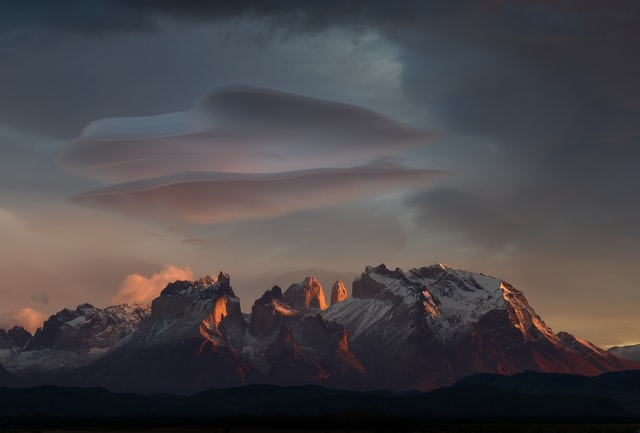

In [5]:
# Load each of the images
photos = [Image.open(os.path.join(img_folder, photo_path)) for photo_path in os.listdir(img_folder)]
photos[0]

In [9]:
import random

train_dataset = []
for idx in range(0, len(photos), 2):
    # We can use image pairs directly. Because our images aren't labeled, we use a random label as an example
    train_dataset.append(InputExample(texts=[photos[idx], photos[idx + 1]], label=random.choice([0, 1])))
    
    # Or images and text together
    train_dataset.append(InputExample(texts=[photos[idx], "This is the caption"], label=1))
    train_dataset.append(InputExample(texts=[photos[idx], "This is another unrelated caption"], label=0))

    # Or just texts
    train_dataset.append(InputExample(texts=["This is a caption", "This is a similar caption"], label=1))
    train_dataset.append(InputExample(texts=["This is a caption", "This is an unrelated caption"], label=0))


In [10]:
# We'll create a DataLoader that batches our data and prepare a contrastive loss function

train_dataloader = DataLoader(train_dataset, shuffle=True, batch_size=4)
train_loss = losses.ContrastiveLoss(model=model)

In [11]:
# Now we can fine-tune our model on the labeled image pairs
model.fit([(train_dataloader, train_loss)], epochs=5, show_progress_bar=True)

Epoch: 100%|██████████| 5/5 [00:57<00:00, 11.43s/it]
